In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import sys
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT / "src"))

from datasets import get_train_val_loaders
from models import create_resnet18


In [2]:
train_loader, val_loader, train_size, val_size = get_train_val_loaders(
    data_root=str(PROJECT_ROOT / "data" / "datasets"),
    batch_size=32,
    num_workers=4,
    image_size=224,
)

train_size, val_size

(20000, 5000)

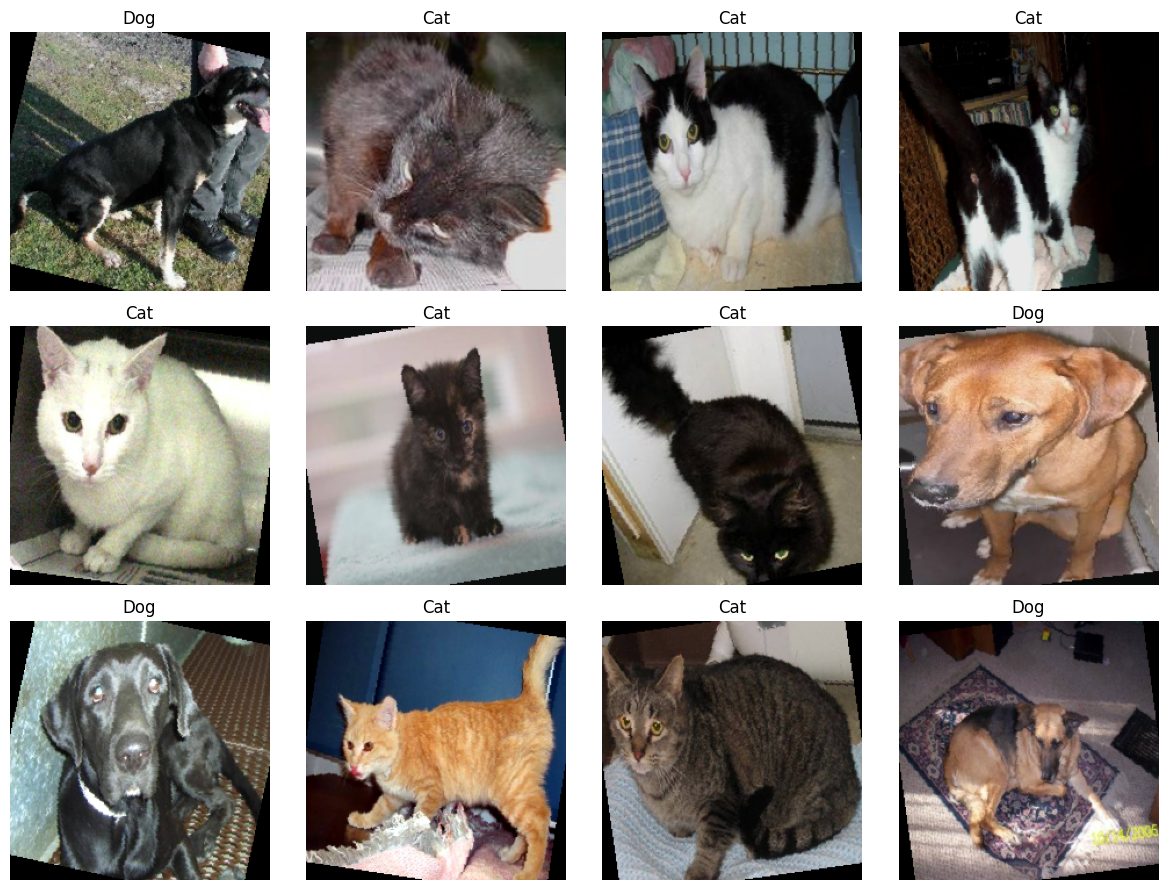

In [3]:
images, labels = next(iter(train_loader))

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.flatten()

for img, label, ax in zip(images[:12], labels[:12], axes):
    img_np = img.permute(1, 2, 0).numpy()
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)
    ax.imshow(img_np)
    ax.set_title("Dog" if label==1 else "Cat")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [4]:
model_path = PROJECT_ROOT / "models" / "best_dogs_cats_resnet18.pth"

model = create_resnet18(num_classes=2, pretrained=False, freeze_backbone=False)
model.load_state_dict(torch.load(model_path, map_location="cpu"))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

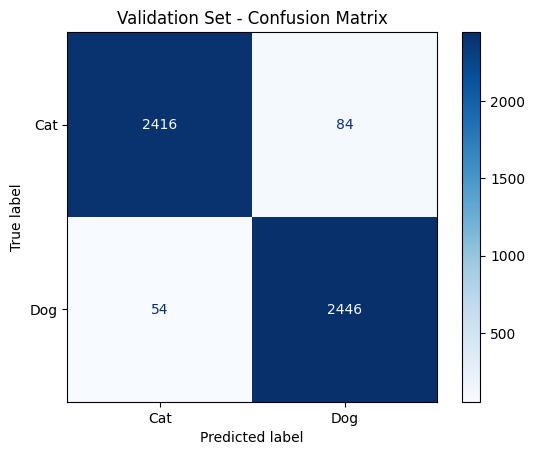

In [5]:
all_labels = []
all_preds = []

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        all_labels.extend(labels.numpy())
        all_preds.extend(preds.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Cat", "Dog"])
disp.plot(cmap="Blues")
plt.title("Validation Set - Confusion Matrix")
plt.show()


Project root: /home/nixon/projects/ie4483-dogs-vs-cats
Log path: /home/nixon/projects/ie4483-dogs-vs-cats/models/dogs_cats_training_logs.json


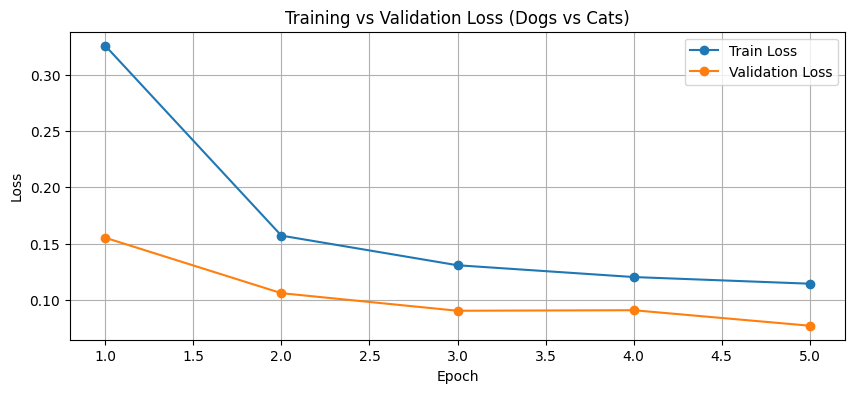

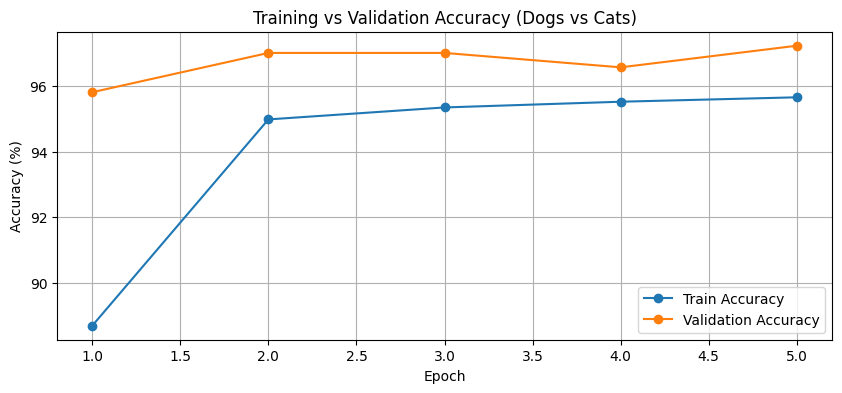

In [7]:
import os
import json
from pathlib import Path

import matplotlib.pyplot as plt

# 1. Locate project root (one level up from notebooks/)
PROJECT_ROOT = Path("..").resolve()
print("Project root:", PROJECT_ROOT)

# 2. Build path to the logs file
log_path = PROJECT_ROOT / "models" / "dogs_cats_training_logs.json"
print("Log path:", log_path)

if not log_path.exists():
    raise FileNotFoundError(f"Training log file not found at: {log_path}")

# 3. Load logs
with open(log_path, "r") as f:
    logs = json.load(f)

train_loss = logs["train_loss"]
val_loss   = logs["val_loss"]
train_acc  = logs["train_acc"]
val_acc    = logs["val_acc"]

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 4))
plt.plot(epochs, train_loss, marker="o", label="Train Loss")
plt.plot(epochs, val_loss, marker="o", label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Dogs vs Cats)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(epochs, [a * 100 for a in train_acc], marker="o", label="Train Accuracy")
plt.plot(epochs, [a * 100 for a in val_acc], marker="o", label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy (Dogs vs Cats)")
plt.grid(True)
plt.legend()
plt.show()
